#Web Mining And Retrieval Course 2022-2023 - Neural Network Lab

**Author: C.D. Hromei (by using a script from Beiqi Zhou)**  
*Last modified: May 2023*

[Course Site](http://sag.art.uniroma2.it/didattica/basili/WmIR_22_23/)



# Guide To Sequence Tagging With Neural Networks In Python

This script shows how to implement a **Named Entity Recognizer** with a **Bidirectional LSTM** in Python using Keras. This example has been taken form the following link, where you will find more examples and more complex architectures.

https://zhoubeiqi.medium.com/named-entity-recognition-ner-using-keras-lstm-spacy-da3ea63d24c5



##The task: Named-Entity Recognition

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*7Rhj-zxvJGG_Pw7cQSoa6w.png)

*Named-entity recognition* (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entity mentions in unstructured text into pre-defined categories such as the person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

The task here is modeled as a sequential labeling task where each word is assigned to a label reflecting the possible Named-Entity it expresses. 

The IOB format (short for inside, outside, beginning) is a common tagging format for defining labels useful for the task. It was presented by Ramshaw and Marcus in their paper "Text Chunking using Transformation-Based Learning", 1995. 
The `B-` prefix before a tag indicates that the tag is the beginning of a chunk, and an `I-` prefix before a tag indicates that the tag is inside a chunk. The `B-` tag is used only when a tag is followed by a tag of the same type without O tokens between them. An `O` tag indicates that a token belongs to no chunk.

An example with IOB format:

```
Back        O
in          O
2000        B-Time
,           O
People      B-Publisher
Magazine    I-Publisher
highlighted O
Prince      B-Person
Williams    I-Person
...
```




#A recurrent  neural model for the NERC task

The idea is to use two LSTMs, one reading each word in a sentence from beginning to end and another reading the same but from end to beginning, producing for each word, a vector representation made from both the un-folded LSTM (i.e., forward and backward) read up to that word. The intuition is that the vector for each word will take into account the words read/seen before, on both directions. 

Given the two outputs provided for each word (in each direction), a single vector is obtained via concatenation and a linear classifier is applied to assign each work to one tag reflecting the final NER task.

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*FhvqkzjOFJv_J7kThW5pUQ.png)

### Step 1 Set up packages


The Prince, Magazine number 5, was there yesterday.
Prince B-person
Magazine B-org/pub

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.12.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Thu May 18 08:39:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Step 2: Load and Explore the NER Dataset

The dataset is from Kaggle, a highly cited dataset used to train NER projects. It is extracted from the Groningen Meaning Bank (GMB), comprises thousands of sentences and words tagged and built specifically to train the classifier to predict named entities. The dataset contains sentences in English and also an annotation for each word. Here is the essential information about each entity:

*Tagged Entities*:

Tag | Explaination | Example
--- | --- | ---
geo | Geographical Entity | Padania
org | Organization | NATO
per | Person | John
gpe | Geopolitical Entity | Germany
tim | Time indicator | Wednesday
art | Artifact | Pentastar
eve | Event | Armistice
nat | Natural Phenomenon | H5N1

It has in total 35178 unique words in the corpus and 17 unique tags. From the plot below, we can see the word count within each tag group.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
my_path = "drive/MyDrive/Colab Notebooks/PhD/teaching/WMIR/data/ner_data/"

In [ ]:
data = pd.read_csv(my_path + "ner_dataset.csv", encoding="latin1")

data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [ ]:
import plotly.express as px

fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

### Step 3: Data Manipulation (integrate tokens from same sentence)
Now we want to tokenize each word within the sentence and associated a respective Tag.

In [ ]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()



In [ ]:
sentences=sentence_integrate(data)

In [ ]:
import plotly.express as px

fig = px.histogram(pd.DataFrame([len(s) for s in sentences],columns=['length']),x="length",marginal='box')
fig.show()

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Step 4: Build a vocabulary for words and tags
Now we are going to build 2 vocabularies based on the words and tags from step 3.

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

Looking at the word2idx dictionary, each word/token is assigned to a unique index. So, rather than encoding each of these words, we are going to use the indexes and we can retrieve them by passing the indexes into the dictionary to return the corresponding keys.

In [ ]:
tag2idx

{'I-nat': 0,
 'B-per': 1,
 'I-per': 2,
 'I-tim': 3,
 'B-gpe': 4,
 'B-org': 5,
 'I-org': 6,
 'B-art': 7,
 'B-geo': 8,
 'B-nat': 9,
 'B-eve': 10,
 'I-eve': 11,
 'I-gpe': 12,
 'O': 13,
 'B-tim': 14,
 'I-art': 15,
 'I-geo': 16}

### Step 5: Padding the input sentence to the same length (50)

Using Keras, we need to pad each sentence to the same length before feeding it to the model. For example, our input only contains 20 words, we can pad the rest using random padding of zeros. From the sentence length distribution, we can see that the mean value is around 20 words per sentence.  
We choose the padding to be 50, so most of the values do not need to be padded. Our X-vector will be a numerical representation of all our words and our y-vector (target) will be the tags associated with each word.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Step 6: Build and Compile a Bidirectional LSTM Model

First, we split the data into train and test sets. Then, we build our model using Tensorflow Keras. We start with an input layer of shape 50, defined in step 5. Then we add a layer for embeddings and apply a spatial drop out that can drop the entire 1D feature map across all the channels. Finally, we create our bidirectional LSTM.

The next step is to compile our model using an adam optimizer, sparse categorical cross-entropy loss, and an accuracy metric.

- Adam: for stochastic gradient descent for training deep learning models
- Categorical cross-entropy: used for multi-class classification problems.

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*U_IOOibI87l7-R730Vgd6A.png)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras

In [ ]:

model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
Total params: 1,879,750
Trainable params: 1,879,750
Non-trainable params: 0
_________________________________________________________________


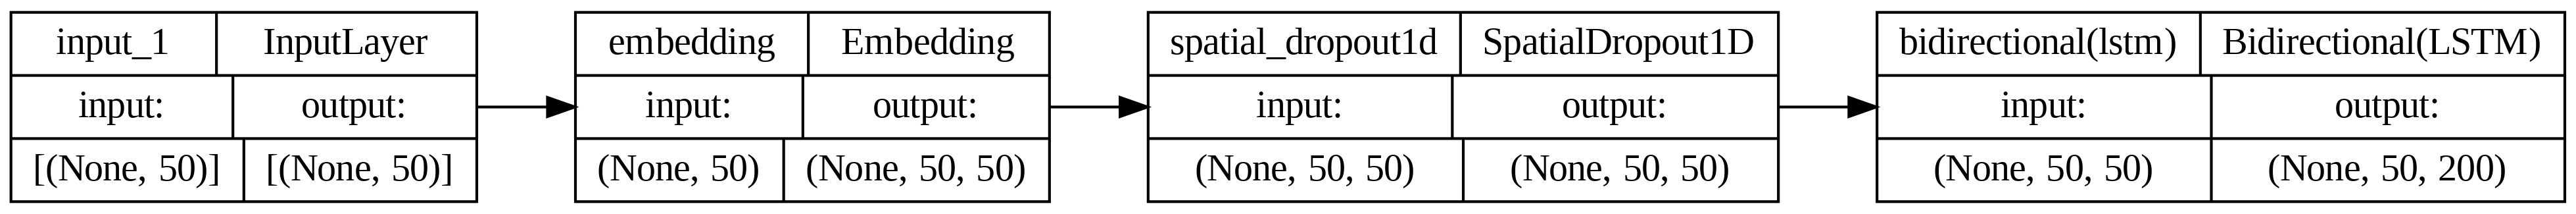

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Step 7: Train the Model

Now we train the model and apply TensorBoard to check the detailed structure and performance.

**Early Stopping**: if the val_accuracy does not improve after 5 epochs, then stop training.

We apply model fit to train our model and use the test data to validate.



In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

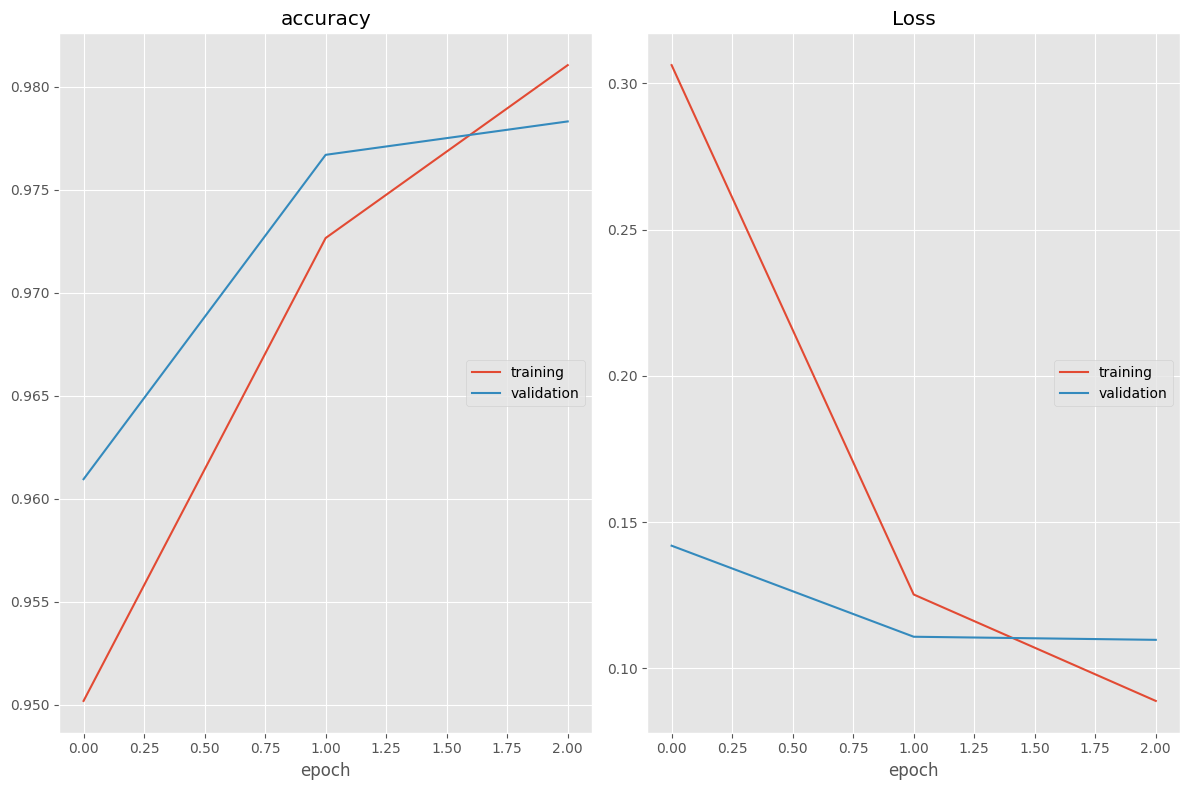

accuracy
	training         	 (min:    0.950, max:    0.981, cur:    0.981)
	validation       	 (min:    0.961, max:    0.978, cur:    0.978)
Loss
	training         	 (min:    0.089, max:    0.306, cur:    0.089)
	validation       	 (min:    0.110, max:    0.142, cur:    0.110)

Epoch 3: val_loss improved from 0.11082 to 0.10976, saving model to model_weights.h5
1199/1199 [==============================] - 499s 417ms/step - loss: 0.0889 - accuracy: 0.9811 - val_loss: 0.1098 - val_accuracy: 0.9783
CPU times: user 32min 42s, sys: 2min 51s, total: 35min 34s
Wall time: 25min 26s


In [ ]:
%%time

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
    
)

Over here, we have the model accuracy and loss using the train and test datasets. We can see that the accuracy is over 97% which is pretty high.

### Step 8: Evaluate the performance of Named Entity Recognition Model

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
75/75 [==============================] - 2s 32ms/step - loss: 0.1098 - accuracy: 0.9783
test loss: 0.10976231098175049 
test accuracy: 0.9783214926719666 


In [ ]:
i = np.random.randint(0, x_test.shape[0])
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 3264
1/1 [==============================] - 0s 50ms/step
Word           True 	 Pred

------------------------------
North          B-geo	B-geo
Korea          I-geo	I-geo
has            O	O
called         O	O
Vice           O	O
President      B-per	B-per
Dick           I-per	I-per
Cheney         I-per	I-per
a              O	O
"              O	O
bloodthirsty   O	O
beast          O	O
"              O	O
and            O	O
said           O	O
his            O	O
comments       O	O
describing     O	O
ruler          O	O
Kim            B-per	B-per
Jong-il        I-per	I-per
as             O	O
"              O	O
irresponsible  O	O
"              O	O
could          O	O
keep           O	O
Pyongyang      O	B-geo
away           O	O
from           O	O
future         O	O
nuclear        O	O
negotiations   O	O
.              O	O
Lavrov         O	O
Lavrov         O	O
Lavrov         O	O
Lavrov         O	O
Lavrov         O	O
Lavrov         O	O
Lavrov         O	O
Lavrov         O	O
Lavrov  

## Exercise

Measure the NERC quality using Precision and Recall over entities (instead that accuracy over tokens). For example:

Words | True Tag | Pred Tag
--- | --- | --- 
Shaima | B-per | B-org
Rezayee | I-per | I-per
had | O | O
presented | O | O
a | O | O
music | O | O
program | O | O
on | O | O
the | O | O
privately-run | O | B-geo
television | O | O
channel | O | O
Tolo | B-org | B-geo
TV | I-org | O
, | O | O
and | O | O
was | O | O
shot | O | O
in | O | O
the | O | O
head | O | O
in | O | O
the | B-geo | O
Kabul | I-geo | B-geo
neighborhood | O | O
of | O | O
Char | B-org | O
Qala | I-org | I-geo
on | O | O
Wednesday | B-tim | B-tim


(Shaima, B-per), (Rezayee, I-per) is an entity, resulting into (Shaima Rezayee, per). The prediction (Shaima, org) and (Rezayee, per) is totally wrong, resulting in 2 FP and 1 FN.


## Exercise 

Extends the training material with some further annotated dataset (e.g., by automatically annotating Wikipedia documents) to improve the performances seen during the lessons